# <center>Лабораторна робота №3 з дисципліни "Машинне навчання".

# <center>Виконав: Терещенко Олексій, ДА-21.


In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Зчитаємо дані з csv файлів. Використовуємо тренувальний та тестовий набори даних:


In [277]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

Подивимось перші кілька рядків та колонок нашого набору даних:


In [278]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [279]:
test_data.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

Перевіримо кількість рядків і колонок (shape) наших даних.


In [280]:
train_data.shape

(891, 12)

In [281]:
test_data.shape

(418, 11)

Визначимо типи даних і їх частоти.


In [282]:
train_data.dtypes.value_counts()

int64      5
object     5
float64    2
Name: count, dtype: int64

In [283]:
test_data.dtypes.value_counts()

object     5
int64      4
float64    2
Name: count, dtype: int64

Знайдемо кількість пропущених значень та унікальних значень у кожній колонці.


In [284]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [285]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [286]:
train_data.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [287]:
test_data.nunique()

PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64

Приберемо айдішніки та колонки, у яких більше 30% даних пропущено, та подивимось чи є дублікати.


In [288]:
train_data = train_data.drop(columns=["Survived"])
train_data = train_data.drop(columns=["PassengerId"])

test_data = test_data.drop(columns=["PassengerId"])

In [289]:
train_data = train_data.drop(
    train_data.columns[train_data.isnull().sum() > 267], axis=1
)

test_data = test_data.drop(test_data.columns[test_data.isnull().sum() > 125], axis=1)

In [290]:
train_data[train_data.duplicated()]

Empty DataFrame
Columns: [Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked]
Index: []

In [291]:
test_data[test_data.duplicated()]

Empty DataFrame
Columns: [Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked]
Index: []

Дублікатів пассажирів немає. Можна тоді прибрати і поле "Name" і "Ticket", адже вони унікальні для майже кожного пассажира.


In [292]:
train_data = train_data.drop(columns=["Name"])
train_data = train_data.drop(columns=["Ticket"])

test_data = test_data.drop(columns=["Name"])
test_data = test_data.drop(columns=["Ticket"])

Подивимось на типи колонок та кількість унікальних значень.


In [293]:
column_info = pd.DataFrame(
    {
        "Column": train_data.columns,
        "Type": train_data.dtypes,
        "Unique Values": train_data.nunique(),
        "Missing Values": train_data.isnull().sum(),  # Кількість пропущених значень
    }
)

print(column_info)

            Column     Type  Unique Values  Missing Values
Pclass      Pclass    int64              3               0
Sex            Sex   object              2               0
Age            Age  float64             88             177
SibSp        SibSp    int64              7               0
Parch        Parch    int64              7               0
Fare          Fare  float64            248               0
Embarked  Embarked   object              3               2


Замінимо категоріальні дані на числові за допомогою OneHotEncoder. Спочатку заповнимо пропущені значення Embarked.


In [294]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd

# Створимо копії даних для демонстрації
train_data_copy = train_data.copy()
test_data_copy = test_data.copy()

# **Обробка Embarked**
# Заповнюємо пропуски модою
train_data_copy["Embarked"].fillna(train_data_copy["Embarked"].mode()[0], inplace=True)
test_data_copy["Embarked"].fillna(test_data_copy["Embarked"].mode()[0], inplace=True)

# Використовуємо OneHotEncoder для Embarked
encoder_embarked = OneHotEncoder()
embarked_train_encoded = encoder_embarked.fit_transform(
    train_data_copy[["Embarked"]]
).toarray()
embarked_test_encoded = encoder_embarked.transform(
    test_data_copy[["Embarked"]]
).toarray()

# Отримуємо правильні назви колонок
embarked_columns = encoder_embarked.get_feature_names_out(["Embarked"])

# Додаємо закодовані дані назад у DataFrame
embarked_train_columns = pd.DataFrame(
    embarked_train_encoded, columns=embarked_columns, index=train_data_copy.index
)
embarked_test_columns = pd.DataFrame(
    embarked_test_encoded, columns=embarked_columns, index=test_data_copy.index
)

train_data_copy = pd.concat([train_data_copy, embarked_train_columns], axis=1).drop(
    "Embarked", axis=1
)
test_data_copy = pd.concat([test_data_copy, embarked_test_columns], axis=1).drop(
    "Embarked", axis=1
)

# **Обробка Sex**
# Використовуємо LabelEncoder для Sex
label_encoder_sex = LabelEncoder()
train_data_copy["Sex"] = label_encoder_sex.fit_transform(train_data_copy["Sex"])
test_data_copy["Sex"] = label_encoder_sex.transform(test_data_copy["Sex"])

C:\Users\alext\AppData\Local\Temp\ipykernel_31316\2314903885.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data_copy["Embarked"].fillna(train_data_copy["Embarked"].mode()[0], inplace=True)
C:\Users\alext\AppData\Local\Temp\ipykernel_31316\2314903885.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

In [295]:
train_data_copy.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_C  Embarked_Q  \
0       3    1  22.0      1      0   7.2500         0.0         0.0   
1       1    0  38.0      1      0  71.2833         1.0         0.0   
2       3    0  26.0      0      0   7.9250         0.0         0.0   
3       1    0  35.0      1      0  53.1000         0.0         0.0   
4       3    1  35.0      0      0   8.0500         0.0         0.0   

   Embarked_S  
0         1.0  
1         0.0  
2         1.0  
3         1.0  
4         1.0

In [296]:
test_data_copy.head()

Pclass  Sex   Age  SibSp  Parch     Fare  Embarked_C  Embarked_Q  \
0       3    1  34.5      0      0   7.8292         0.0         1.0   
1       3    0  47.0      1      0   7.0000         0.0         0.0   
2       2    1  62.0      0      0   9.6875         0.0         1.0   
3       3    1  27.0      0      0   8.6625         0.0         0.0   
4       3    0  22.0      1      1  12.2875         0.0         0.0   

   Embarked_S  
0         0.0  
1         1.0  
2         0.0  
3         1.0  
4         1.0

In [297]:
train_data = train_data_copy
test_data = test_data_copy

In [298]:
train_data.shape

(891, 9)

In [299]:
test_data.shape

(418, 9)

In [300]:
column_info = pd.DataFrame(
    {
        "Column": train_data.columns,
        "Type": train_data.dtypes,
        "Unique Values": train_data.nunique(),
        "Missing Values": train_data.isnull().sum(),  # Кількість пропущених значень
    }
)

print(column_info)

                Column     Type  Unique Values  Missing Values
Pclass          Pclass    int64              3               0
Sex                Sex    int64              2               0
Age                Age  float64             88             177
SibSp            SibSp    int64              7               0
Parch            Parch    int64              7               0
Fare              Fare  float64            248               0
Embarked_C  Embarked_C  float64              2               0
Embarked_Q  Embarked_Q  float64              2               0
Embarked_S  Embarked_S  float64              2               0


In [301]:
column_info = pd.DataFrame(
    {
        "Column": test_data.columns,
        "Type": test_data.dtypes,
        "Unique Values": test_data.nunique(),
        "Missing Values": test_data.isnull().sum(),  # Кількість пропущених значень
    }
)

print(column_info)

                Column     Type  Unique Values  Missing Values
Pclass          Pclass    int64              3               0
Sex                Sex    int64              2               0
Age                Age  float64             79              86
SibSp            SibSp    int64              7               0
Parch            Parch    int64              8               0
Fare              Fare  float64            169               1
Embarked_C  Embarked_C  float64              2               0
Embarked_Q  Embarked_Q  float64              2               0
Embarked_S  Embarked_S  float64              2               0


Як можна побачити, у нас є 2 колонки з частково пропущеними значеннями. Зообразимо всі колонки на графіках.


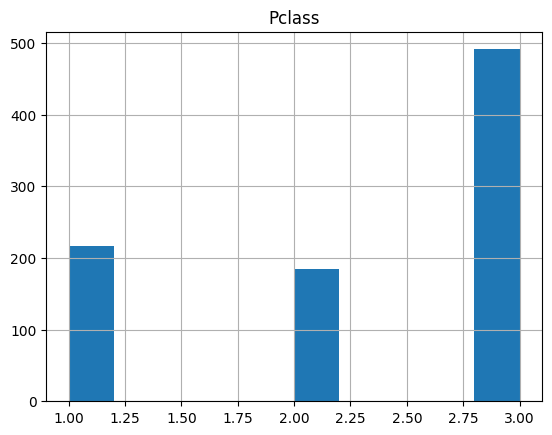

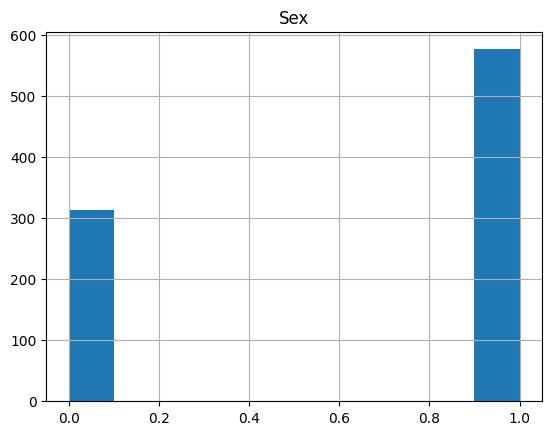

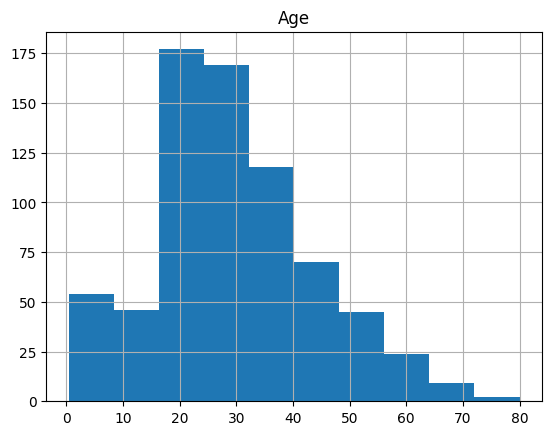

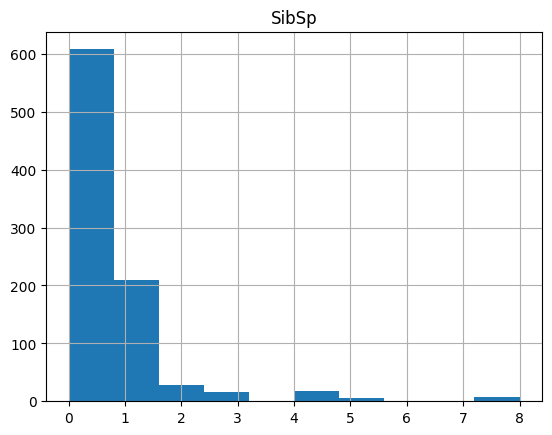

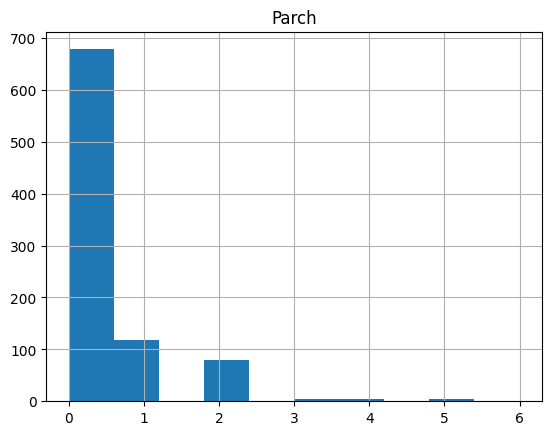

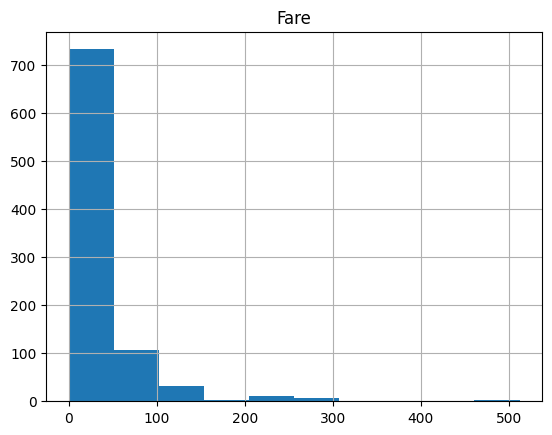

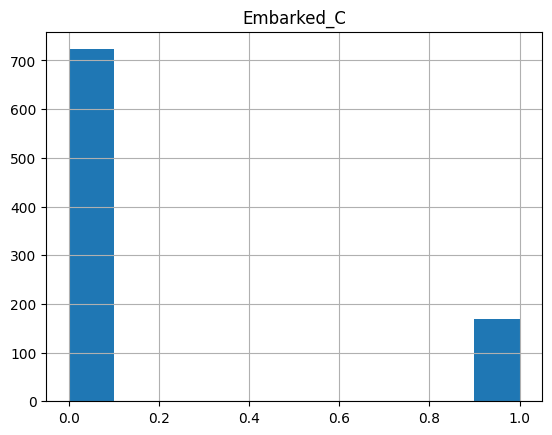

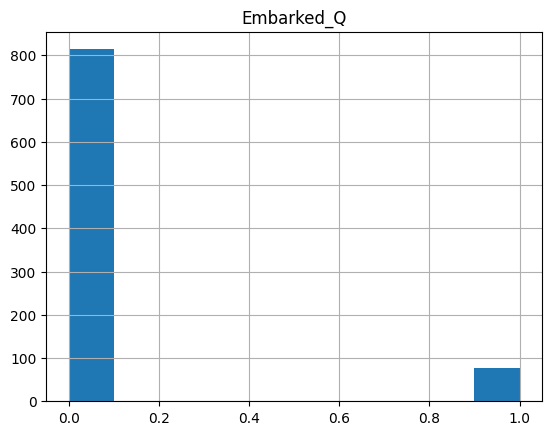

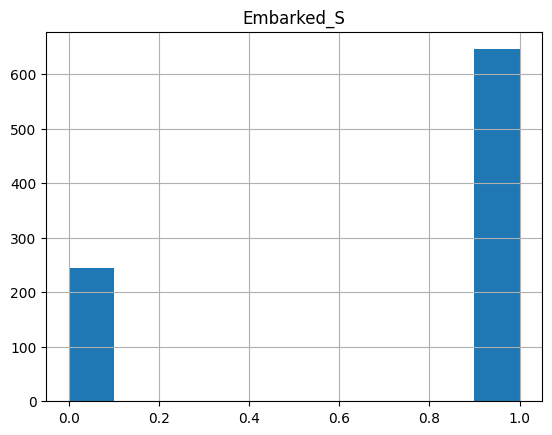

In [302]:
for col in train_data.columns:
    plt.figure()
    train_data[col].hist()
    plt.title(col)
    plt.show()

Надалі будемо працювати лише з тренувальним набором.


Заповнимо пропущені значення медіаною.


In [303]:
train_data["Age"].fillna(train_data["Age"].median(), inplace=True)

C:\Users\alext\AppData\Local\Temp\ipykernel_31316\3432818176.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data["Age"].fillna(train_data["Age"].median(), inplace=True)


In [304]:
train_data.describe(include="all")

Pclass         Sex         Age       SibSp       Parch        Fare  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     2.308642    0.647587   29.361582    0.523008    0.381594   32.204208   
std      0.836071    0.477990   13.019697    1.102743    0.806057   49.693429   
min      1.000000    0.000000    0.420000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000   22.000000    0.000000    0.000000    7.910400   
50%      3.000000    1.000000   28.000000    0.000000    0.000000   14.454200   
75%      3.000000    1.000000   35.000000    1.000000    0.000000   31.000000   
max      3.000000    1.000000   80.000000    8.000000    6.000000  512.329200   

       Embarked_C  Embarked_Q  Embarked_S  
count  891.000000  891.000000  891.000000  
mean     0.188552    0.086420    0.725028  
std      0.391372    0.281141    0.446751  
min      0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000  
50%      0.000000    0.000000    1.000000  
75%      0.000000    0.000000    1.000000  
max      1.000000    1.000000    1.000000

Судячи з графіків, доведется використовувати StandardScaler на числових даних.


Побудуємо кореляційну матрицю:


In [305]:
correlation_matrix = train_data.corr()

correlation_matrix

Pclass       Sex       Age     SibSp     Parch      Fare  \
Pclass      1.000000  0.131900 -0.339898  0.083081  0.018443 -0.549500   
Sex         0.131900  1.000000  0.081163 -0.114631 -0.245489 -0.182333   
Age        -0.339898  0.081163  1.000000 -0.233296 -0.172482  0.096688   
SibSp       0.083081 -0.114631 -0.233296  1.000000  0.414838  0.159651   
Parch       0.018443 -0.245489 -0.172482  0.414838  1.000000  0.216225   
Fare       -0.549500 -0.182333  0.096688  0.159651  0.216225  1.000000   
Embarked_C -0.243292 -0.082853  0.030248 -0.059528 -0.011069  0.269335   
Embarked_Q  0.221009 -0.074115 -0.031415 -0.026354 -0.081228 -0.117216   
Embarked_S  0.074053  0.119224 -0.006729  0.068734  0.060814 -0.162184   

            Embarked_C  Embarked_Q  Embarked_S  
Pclass       -0.243292    0.221009    0.074053  
Sex          -0.082853   -0.074115    0.119224  
Age           0.030248   -0.031415   -0.006729  
SibSp        -0.059528   -0.026354    0.068734  
Parch        -0.011069   -0.081228    0.060814  
Fare          0.269335   -0.117216   -0.162184  
Embarked_C    1.000000   -0.148258   -0.782742  
Embarked_Q   -0.148258    1.000000   -0.499421  
Embarked_S   -0.782742   -0.499421    1.000000

Кореляції між двома змінними немає більше за 0.8, змінювати дані не треба.


Для кластеризації даних використаємо методи k-середніх (k-means) та агломеративну (Agglomerative):


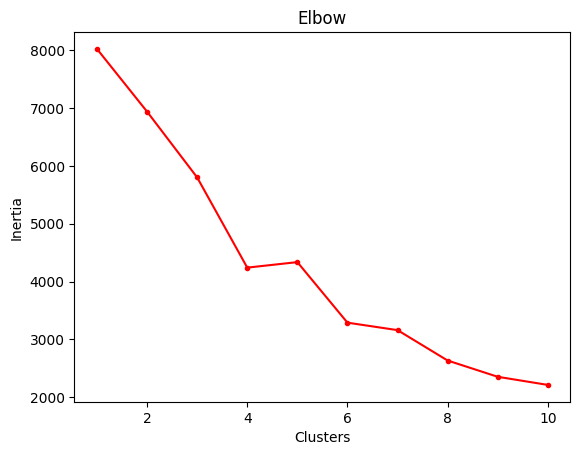

In [306]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(train_data)

inertias_list = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias_list.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias_list, marker=".", color="red")
plt.title("Elbow")
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.show()

Видно, що найбільш оптимальною кількістю кластерів є 4, оскільки на цій кількості починає сповільнюватись спадання. Давайте подивимось кластеризацію з кількістю кластерів 3-9.


c:\Users\alext\OneDrive\Desktop\lab3_ML\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


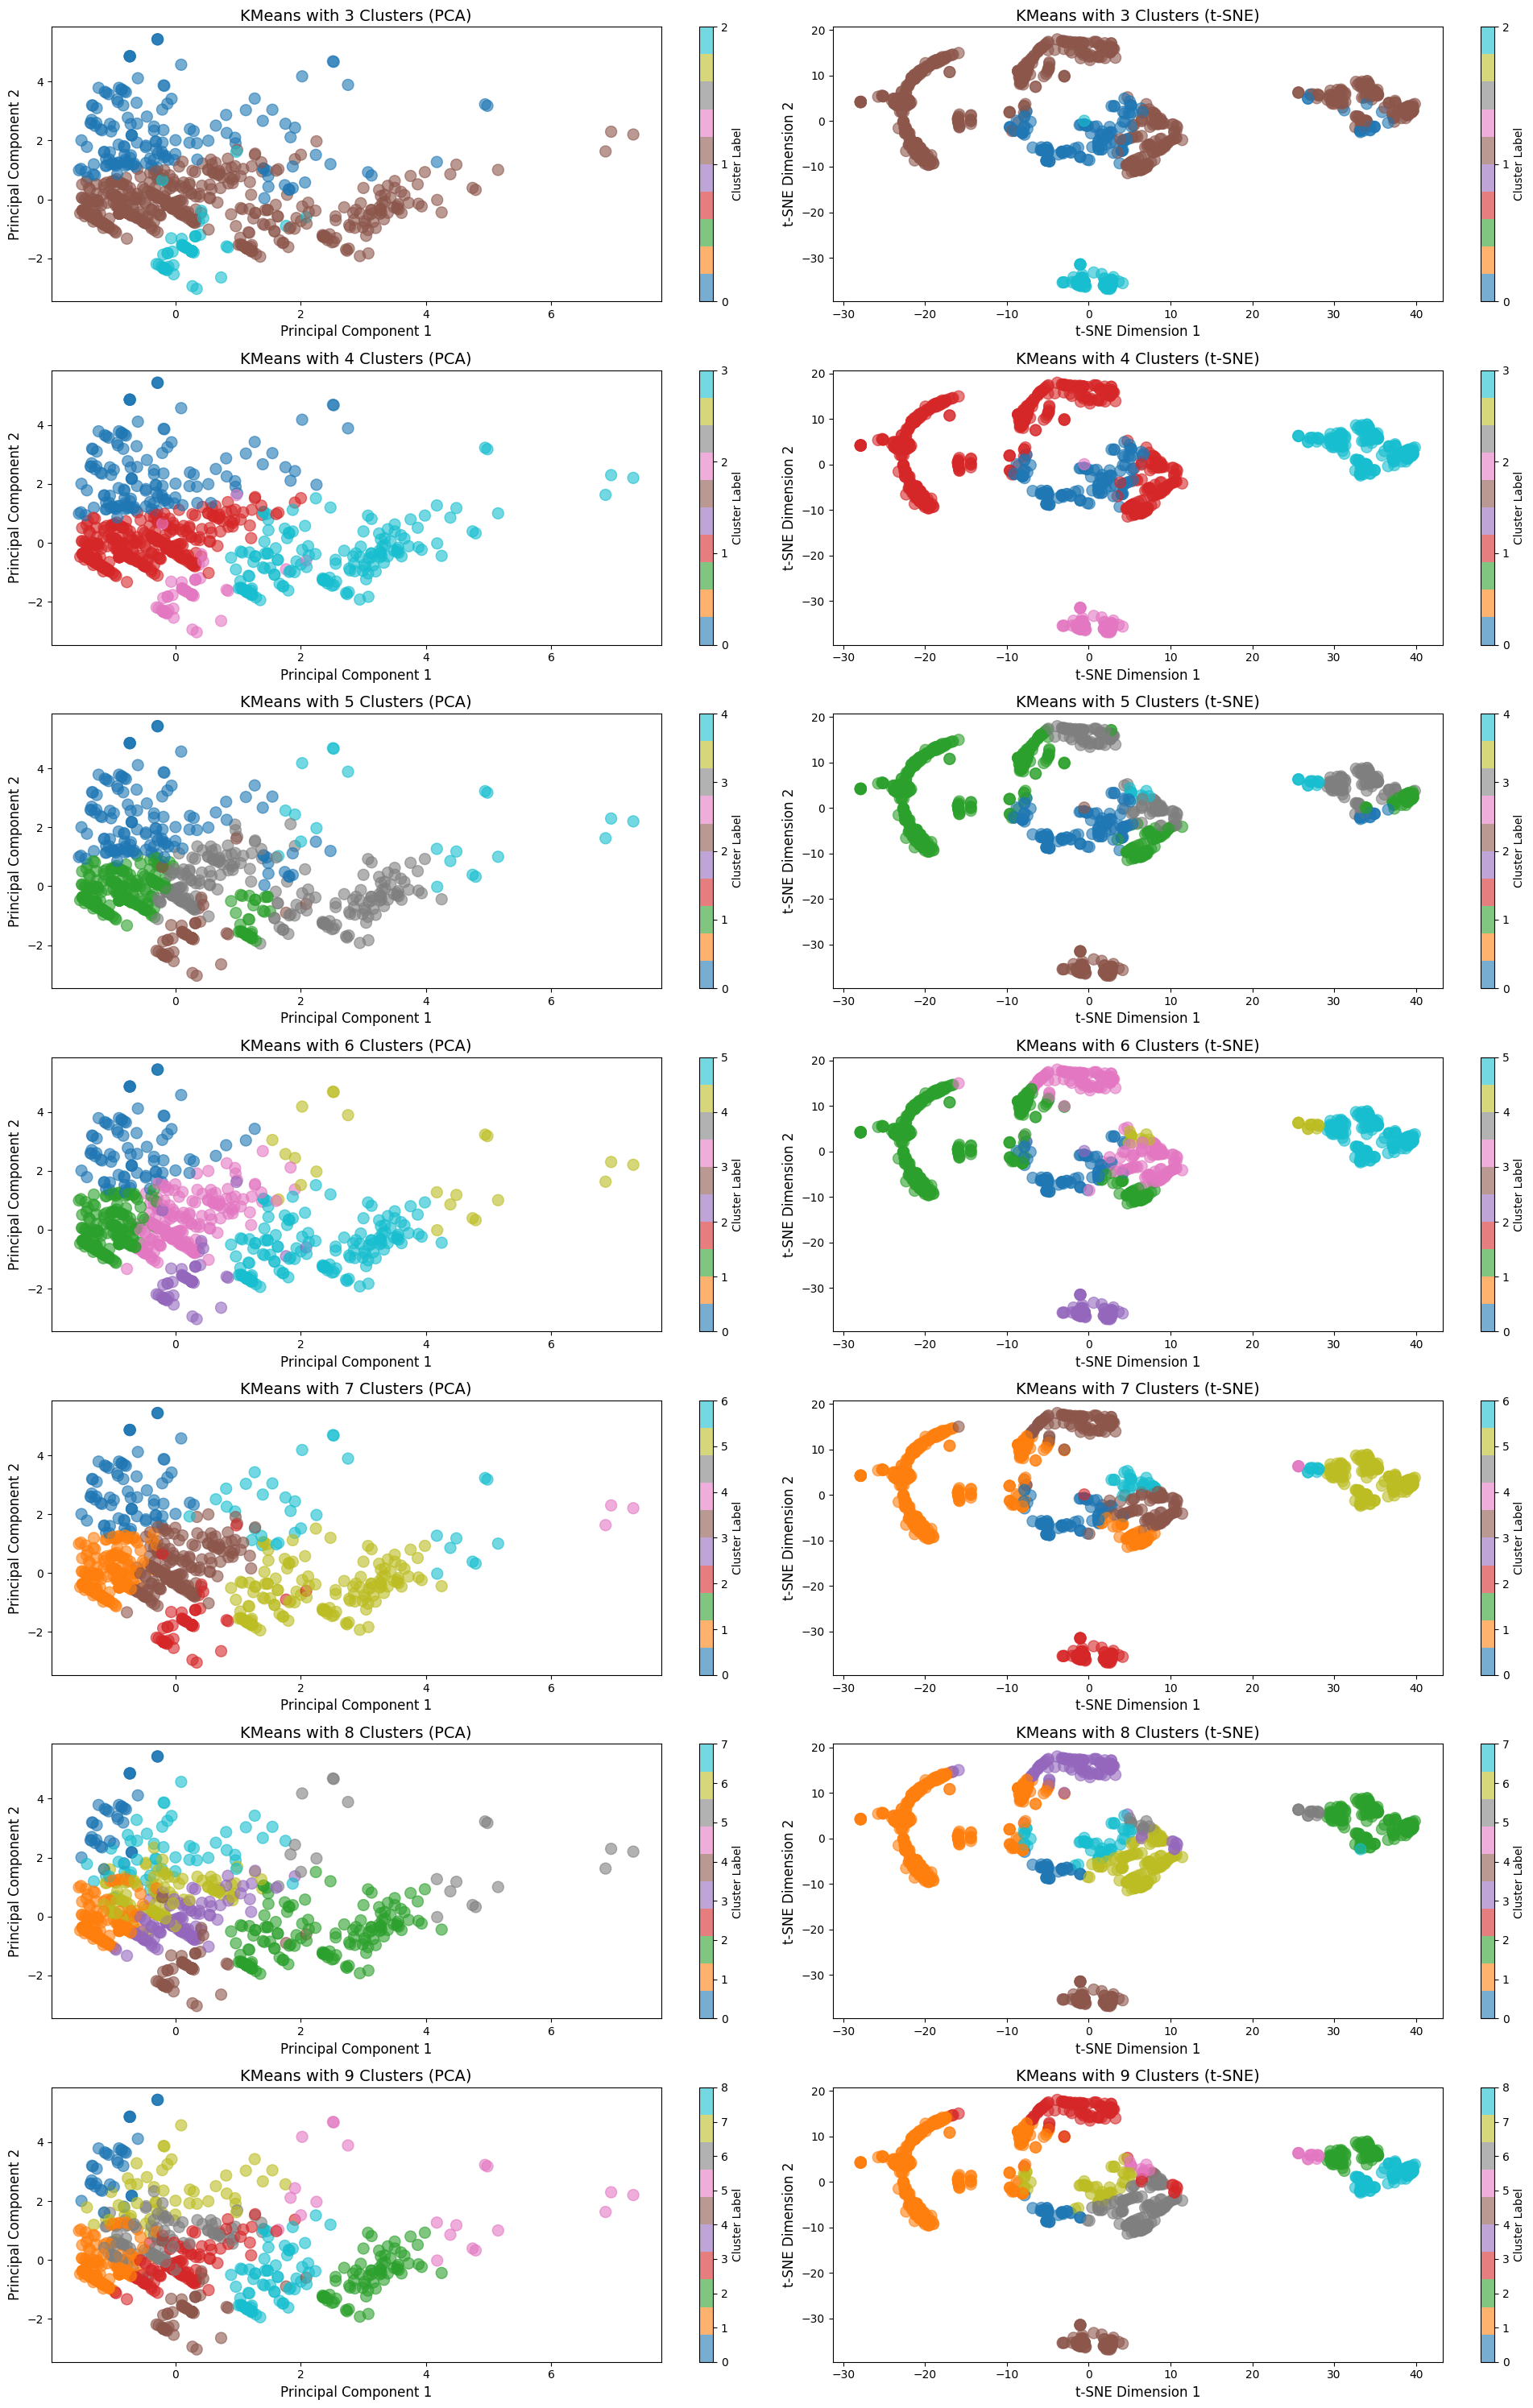

In [307]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(20, 30))

for k in range(3, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    plt.subplot(7, 2, (k - 3) * 2 + 1)
    scatter = plt.scatter(
        X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="tab10", alpha=0.6, s=100
    )
    plt.title(f"KMeans with {k} Clusters (PCA)", fontsize=14)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)

    colorbar = plt.colorbar(scatter, ticks=np.arange(k))
    colorbar.set_label("Cluster Label")

    plt.subplot(7, 2, (k - 3) * 2 + 2)
    scatter = plt.scatter(
        X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap="tab10", alpha=0.6, s=100
    )
    plt.title(f"KMeans with {k} Clusters (t-SNE)", fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)

    colorbar = plt.colorbar(scatter, ticks=np.arange(k))
    colorbar.set_label("Cluster Label")

plt.tight_layout()
plt.show()

Тепер, використаємо агломеративний кластеризатор.


c:\Users\alext\OneDrive\Desktop\lab3_ML\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


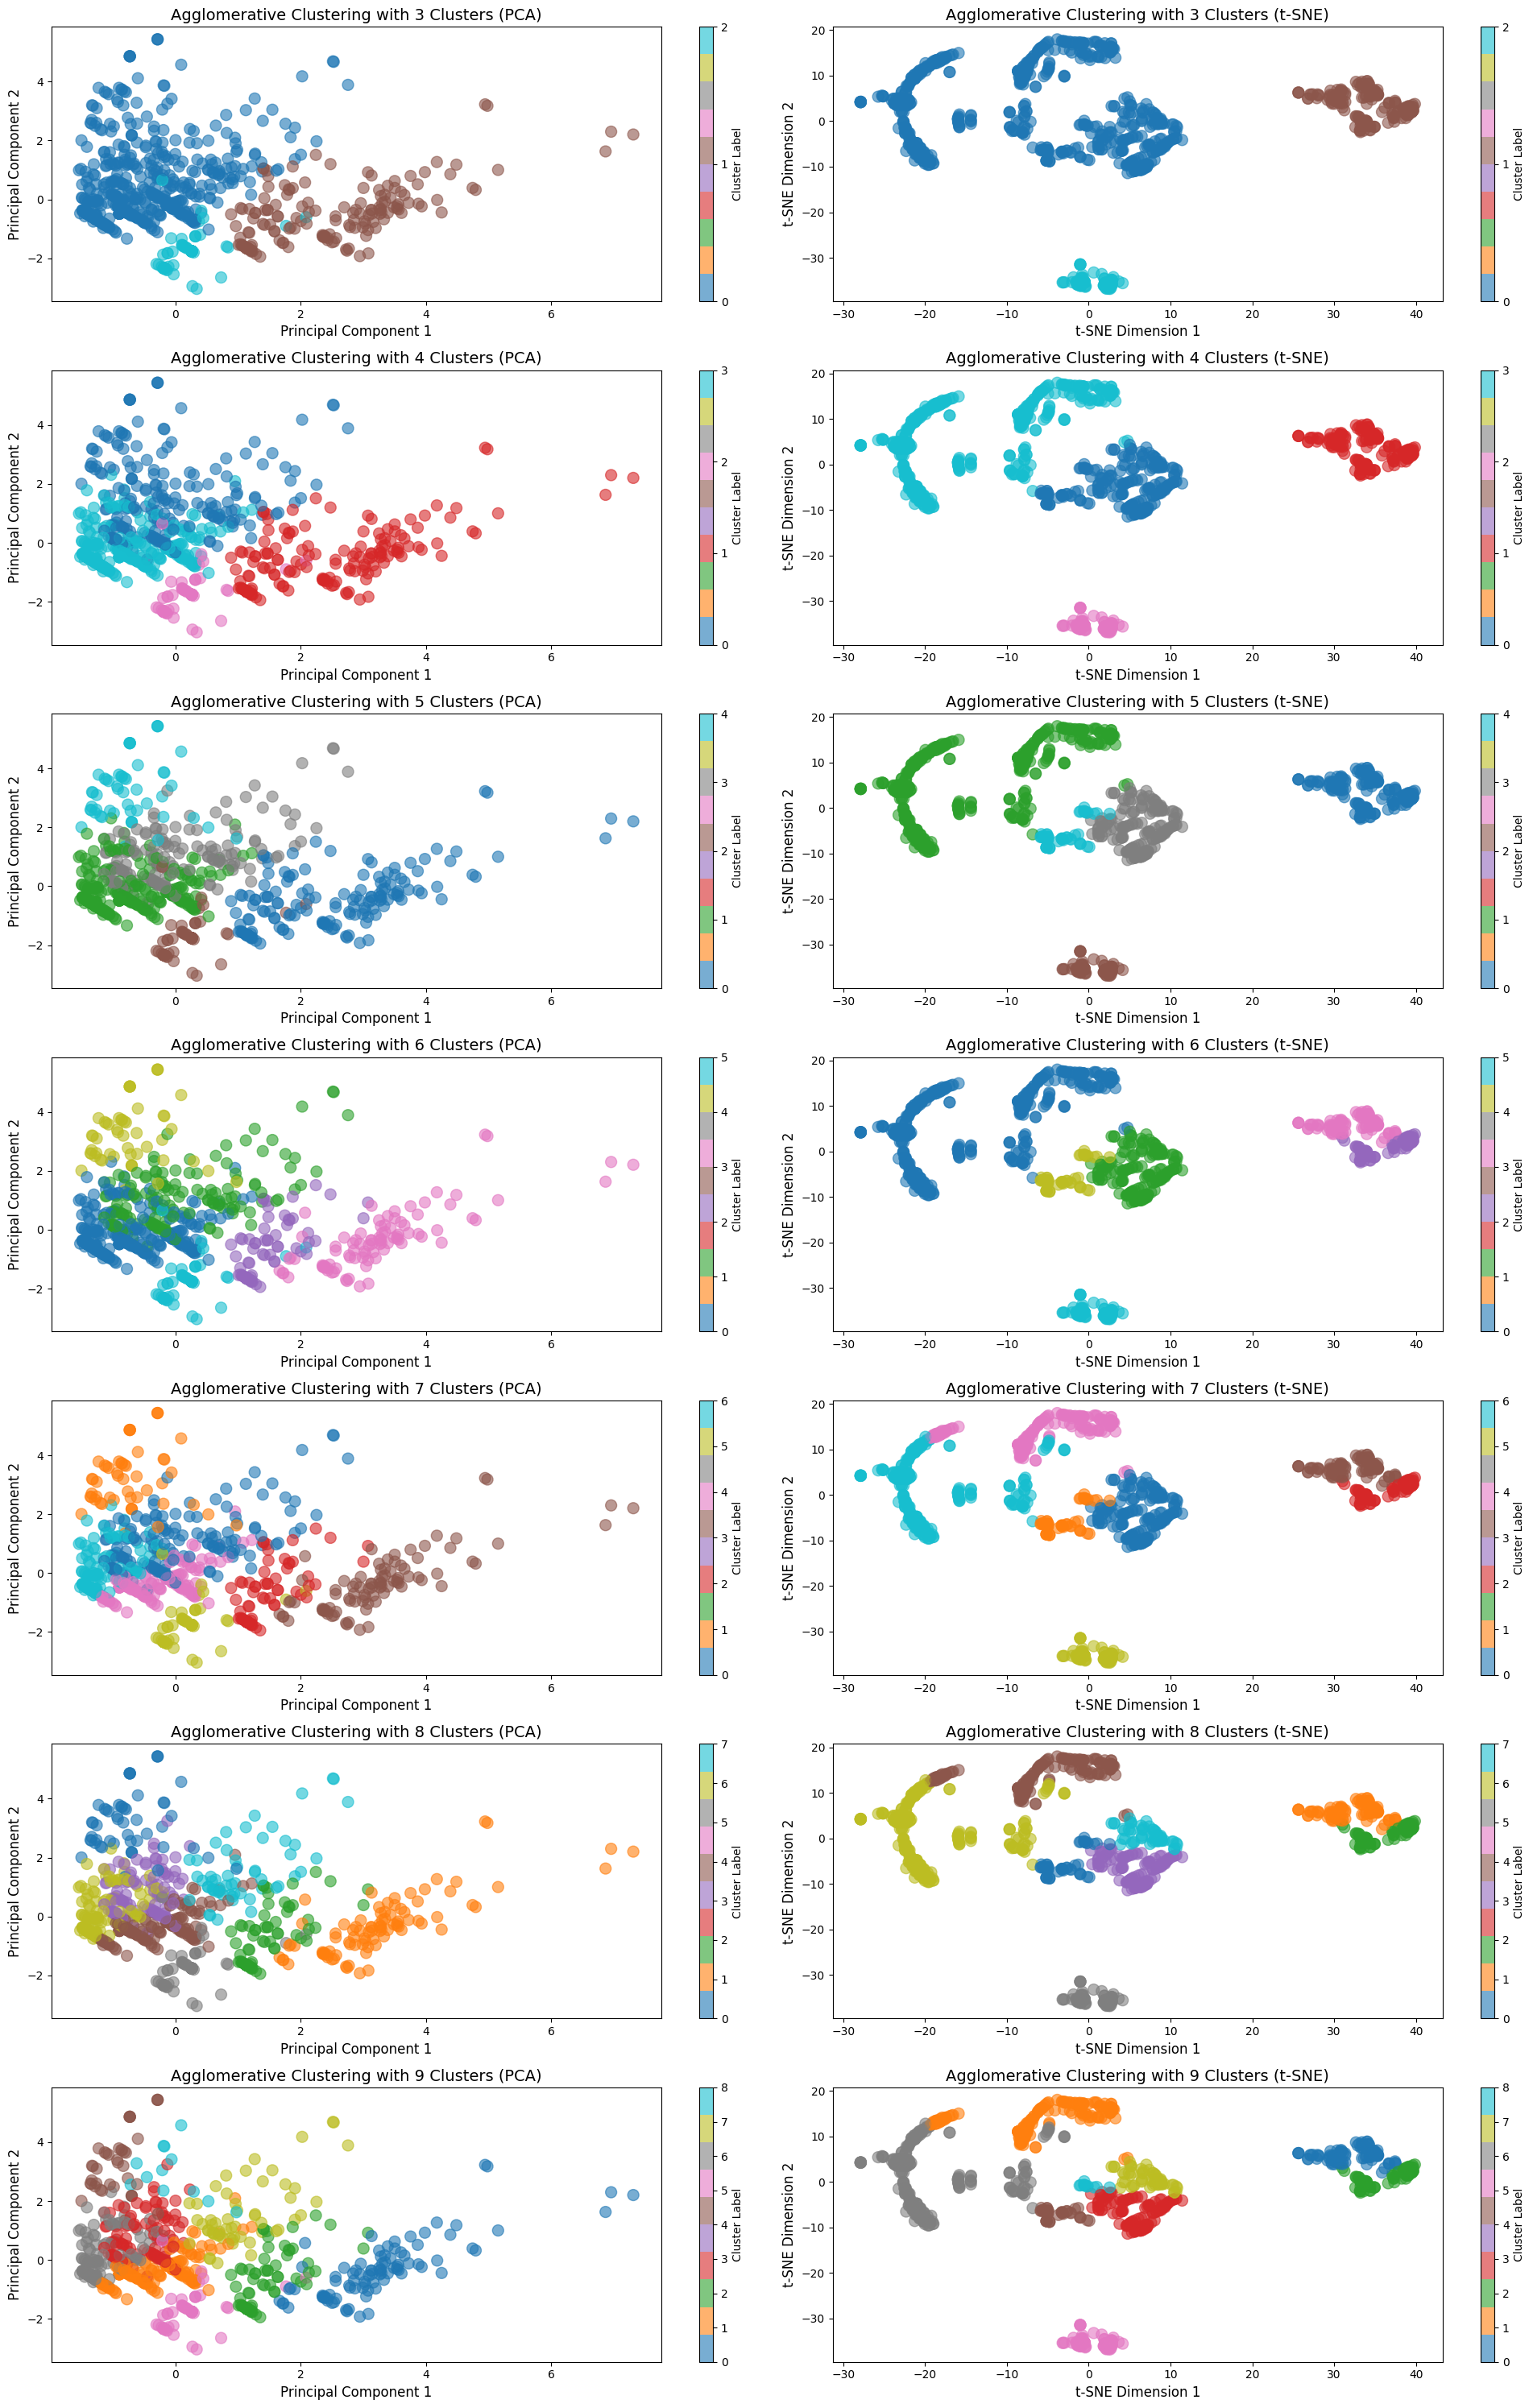

In [308]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(20, 30))

for k in range(3, 10):
    agglomerative = AgglomerativeClustering(n_clusters=k)
    cluster_labels = agglomerative.fit_predict(X_scaled)

    plt.subplot(7, 2, (k - 3) * 2 + 1)
    scatter = plt.scatter(
        X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="tab10", alpha=0.6, s=100
    )
    plt.title(f"Agglomerative Clustering with {k} Clusters (PCA)", fontsize=14)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)

    colorbar = plt.colorbar(scatter, ticks=np.arange(k))
    colorbar.set_label("Cluster Label")

    plt.subplot(7, 2, (k - 3) * 2 + 2)
    scatter = plt.scatter(
        X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap="tab10", alpha=0.6, s=100
    )
    plt.title(f"Agglomerative Clustering with {k} Clusters (t-SNE)", fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)

    colorbar = plt.colorbar(scatter, ticks=np.arange(k))
    colorbar.set_label("Cluster Label")

plt.tight_layout()
plt.show()

Тепер використаємо DBSCAN


c:\Users\alext\OneDrive\Desktop\lab3_ML\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


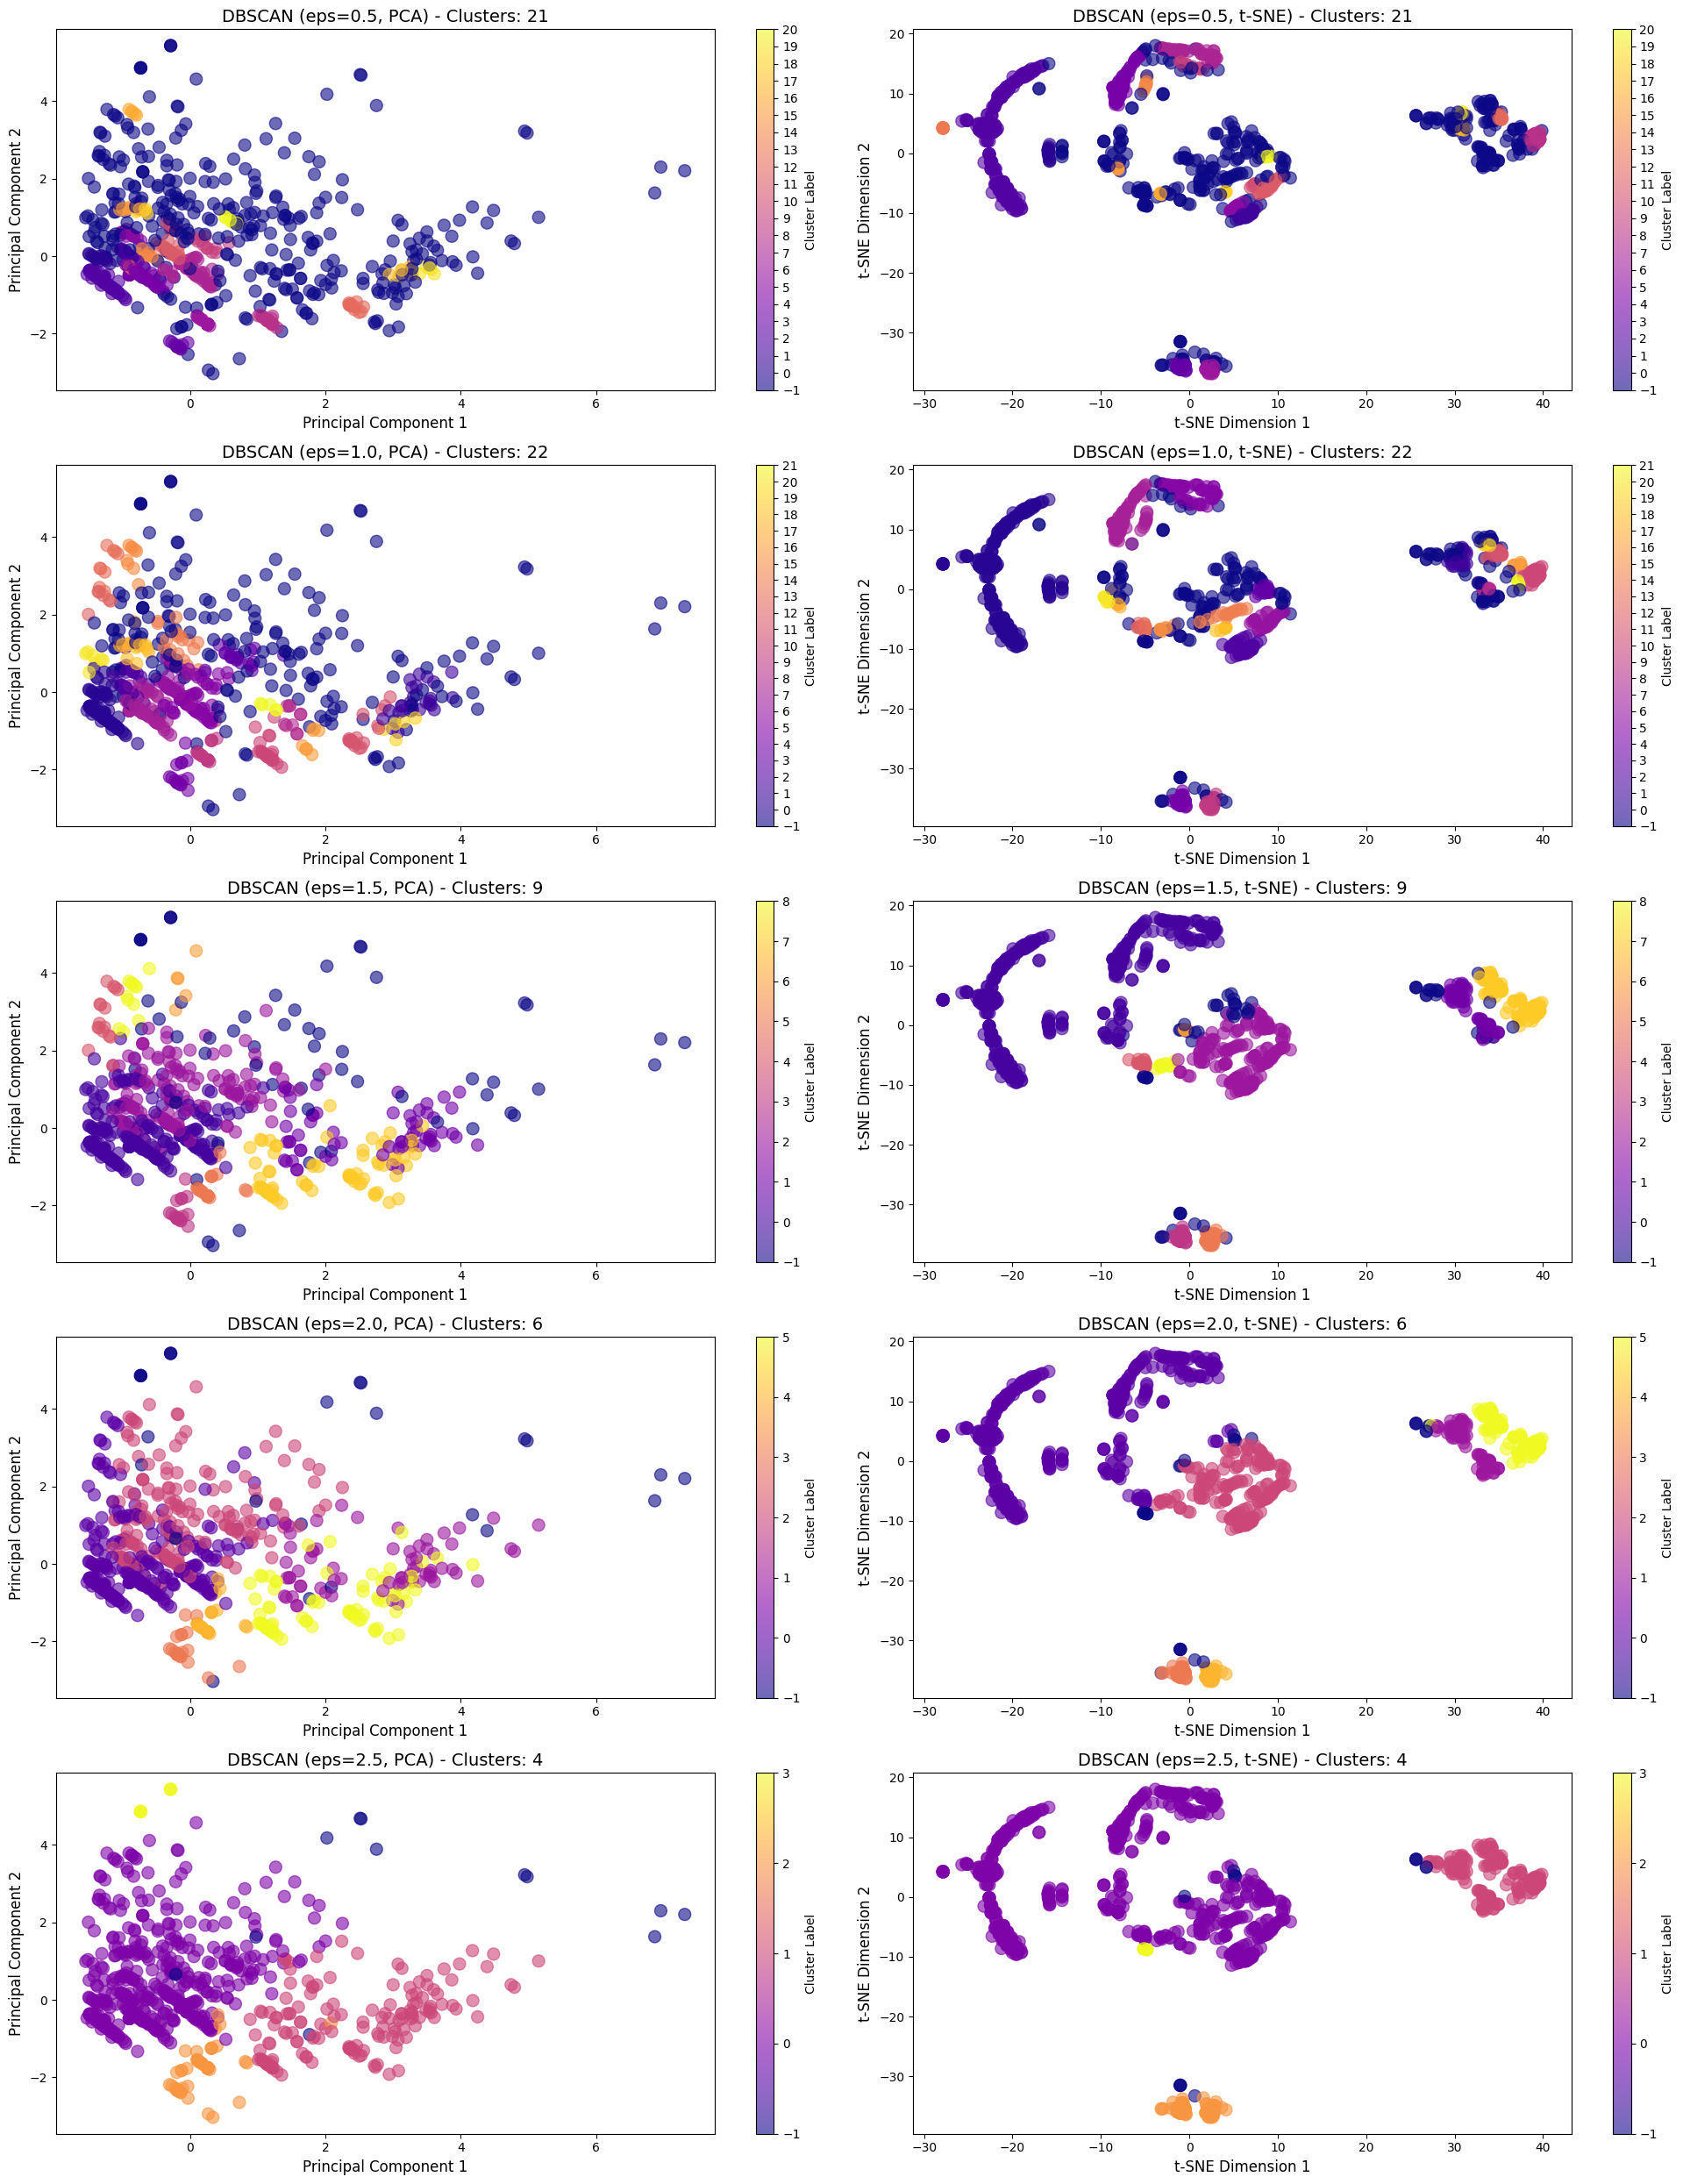

In [309]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=50, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples = 5

plt.figure(figsize=(20, 25))

for i, eps in enumerate(eps_values):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X_scaled)

    unique_labels = np.unique(cluster_labels)
    n_clusters = len(unique_labels[unique_labels >= 0])

    plt.subplot(len(eps_values), 2, i * 2 + 1)
    scatter = plt.scatter(
        X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="plasma", alpha=0.6, s=100
    )
    plt.title(f"DBSCAN (eps={eps}, PCA) - Clusters: {n_clusters}", fontsize=14)
    plt.xlabel("Principal Component 1", fontsize=12)
    plt.ylabel("Principal Component 2", fontsize=12)

    colorbar = plt.colorbar(scatter, ticks=unique_labels)
    colorbar.set_label("Cluster Label")

    plt.subplot(len(eps_values), 2, i * 2 + 2)
    scatter = plt.scatter(
        X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap="plasma", alpha=0.6, s=100
    )
    plt.title(f"DBSCAN (eps={eps}, t-SNE) - Clusters: {n_clusters}", fontsize=14)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)

    colorbar = plt.colorbar(scatter, ticks=unique_labels)
    colorbar.set_label("Cluster Label")

plt.tight_layout()
plt.show()